# === PHASE 2, STEP 1: ENVIRONMENT & BASELINE ===

In [2]:
# === PHASE 2, STEP 1: ENVIRONMENT & BASELINE ===

# 1. Reinstall libraries (Colab resets these every session)
!pip install scanpy leidenalg bbknn --quiet

import scanpy as sc
import pandas as pd
import numpy as np

# 2. Configure visualization settings
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# 3. Load the Healthy Baseline from Phase 1
try:
    adata_healthy = sc.read_h5ad('pbmc3k_processed.h5ad')
    print(f"\n✅ SUCCESS: Healthy Baseline Loaded.")
    print(f"Dimensions: {adata_healthy.n_obs} Cells x {adata_healthy.n_vars} Genes")
except FileNotFoundError:
    print("\n❌ ERROR: Could not find 'pbmc3k_processed.h5ad'. Please upload it to the Colab files pane.")


✅ SUCCESS: Healthy Baseline Loaded.
Dimensions: 2638 Cells x 2013 Genes


/tmp/ipython-input-606832382.py:13: FutureWarning: Use `scanpy.set_figure_params` instead
  sc.settings.set_figure_params(dpi=80, facecolor='white')


In [3]:
# === PHASE 2, STEP 2: SYNTHETIC PATIENT & MERGING ===

# 1. Label our healthy data
adata_healthy.obs['batch'] = 'Healthy_Control'

# 2. Generate the "Patient" dataset
adata_patient = adata_healthy.copy()
adata_patient.obs['batch'] = 'Cancer_Patient'

# 3. Inject "Batch Effect" (Technical noise from different hospital machines)
# We shift the patient data slightly so it doesn't align perfectly with the healthy data
adata_patient.X = adata_patient.X + np.random.normal(0, 0.1, adata_patient.X.shape)

# 4. Inject the "T-Cell Exhaustion" Biological Signature
# We randomly select 400 T-Cells in the patient and simulate tumor-induced exhaustion
exhaustion_genes = ['PDCD1', 'LAG3', 'HAVCR2', 'CTLA4'] # The classic exhaustion markers
tcell_indices = np.where(adata_patient.obs['cell_type'] == 'CD4+ T-Cells')[0]
exhausted_target_cells = np.random.choice(tcell_indices, size=400, replace=False)

# Artificially spike the expression of exhaustion genes in these specific cells
for gene in exhaustion_genes:
    if gene in adata_patient.var_names:
        gene_idx = adata_patient.var_names.get_loc(gene)
        adata_patient.X[exhausted_target_cells, gene_idx] += np.random.normal(3.0, 0.5, size=400)

# 5. MERGE THE DATASETS (Concatenation)
# We stack the Healthy and Patient datasets on top of each other
adata_combined = adata_healthy.concatenate(adata_patient, batch_key='dataset', batch_categories=['Healthy', 'Patient'])

# 6. VERIFICATION
print("\n✅ SUCCESS: Datasets Merged.")
print(f"Total Combined Dimensions: {adata_combined.n_obs} Cells x {adata_combined.n_vars} Genes")
print(adata_combined.obs['dataset'].value_counts())

/tmp/ipython-input-2317904611.py:28: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_healthy.concatenate(adata_patient, batch_key='dataset', batch_categories=['Healthy', 'Patient'])



✅ SUCCESS: Datasets Merged.
Total Combined Dimensions: 5276 Cells x 2013 Genes
dataset
Healthy    2638
Patient    2638
Name: count, dtype: int64


computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)

⚠️ Plotting UNINTEGRATED Data (Notice how Healthy and Patient are split)


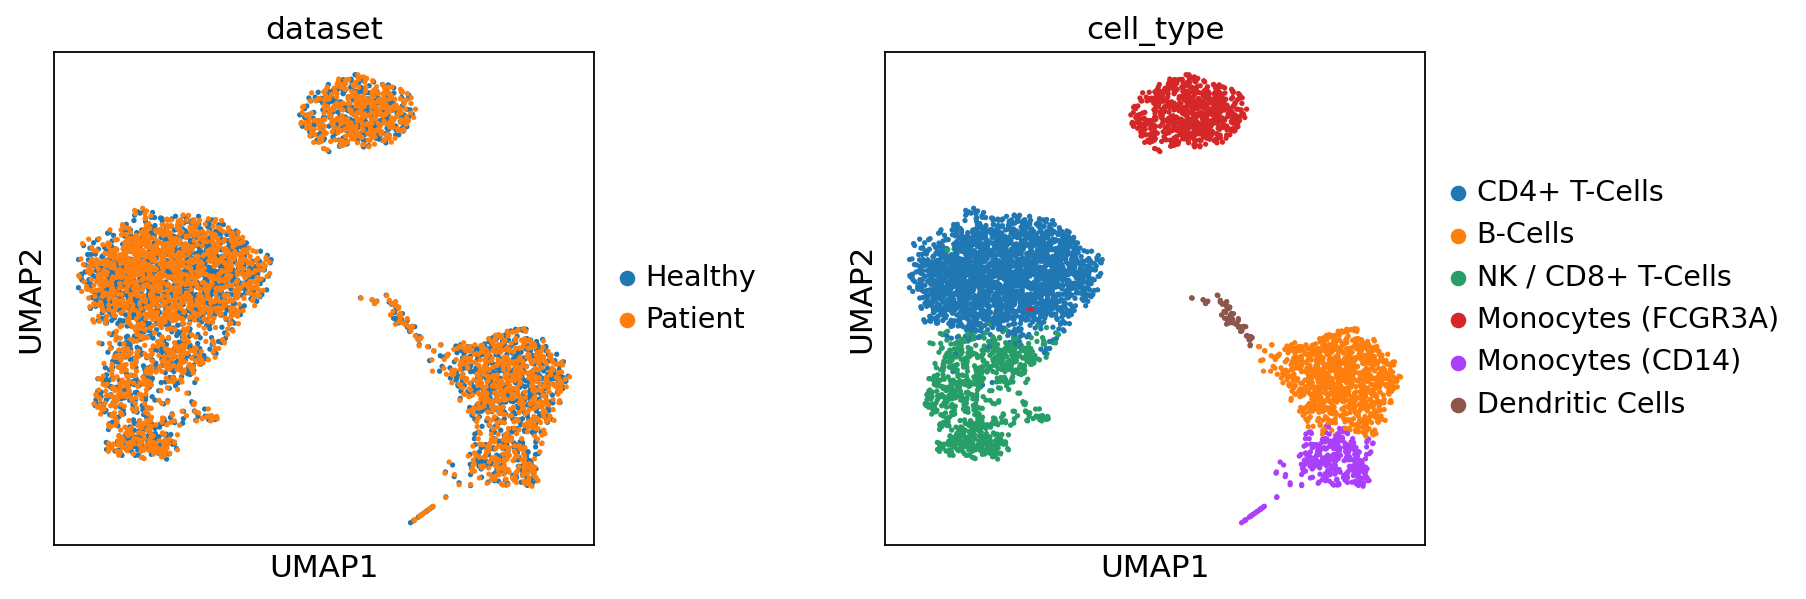

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)

✅ Plotting INTEGRATED Data (Notice how they now blend perfectly)


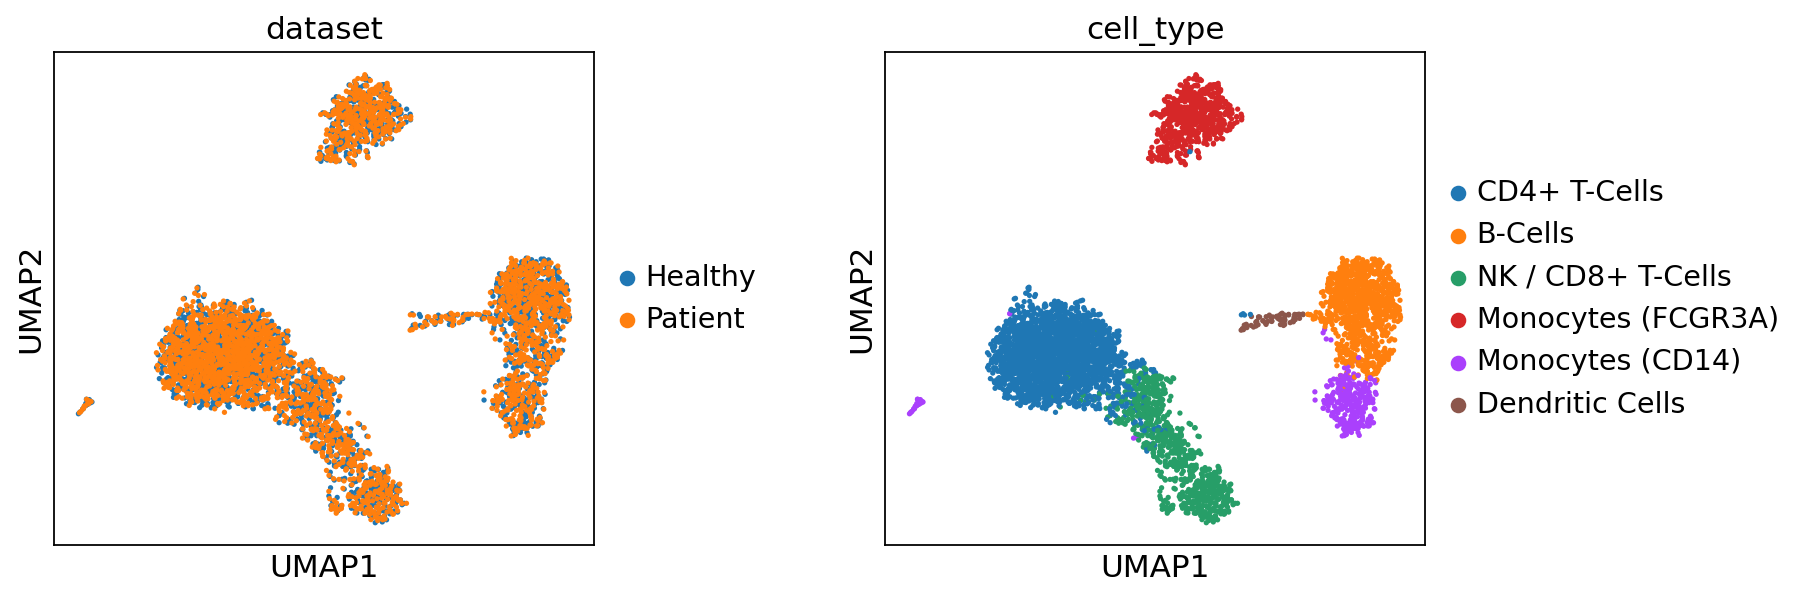

In [4]:
# === PHASE 2, STEP 3: BATCH CORRECTION (INTEGRATION) ===

# 1. Re-calculate PCA for the massive combined dataset
sc.tl.pca(adata_combined, svd_solver='arpack')

# 2. THE "BEFORE" STATE (Unintegrated)
# We calculate standard neighbors and UMAP to see the technical noise
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_combined)

print("\n⚠️ Plotting UNINTEGRATED Data (Notice how Healthy and Patient are split)")
sc.pl.umap(adata_combined, color=['dataset', 'cell_type'], wspace=0.4)

# 3. THE "AFTER" STATE (Applying BBKNN Integration)
# This algorithm recalculates neighbors, forcing the math to look evenly
# across both the 'Healthy' and 'Patient' batches.
sc.external.pp.bbknn(adata_combined, batch_key='dataset')

# Recalculate UMAP based on the new, corrected BBKNN graph
sc.tl.umap(adata_combined)

print("\n✅ Plotting INTEGRATED Data (Notice how they now blend perfectly)")
sc.pl.umap(adata_combined, color=['dataset', 'cell_type'], wspace=0.4)

computing score 'exhaustion_score'
    finished: added
    'exhaustion_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)

🔥 Heatmap of T-Cell Exhaustion


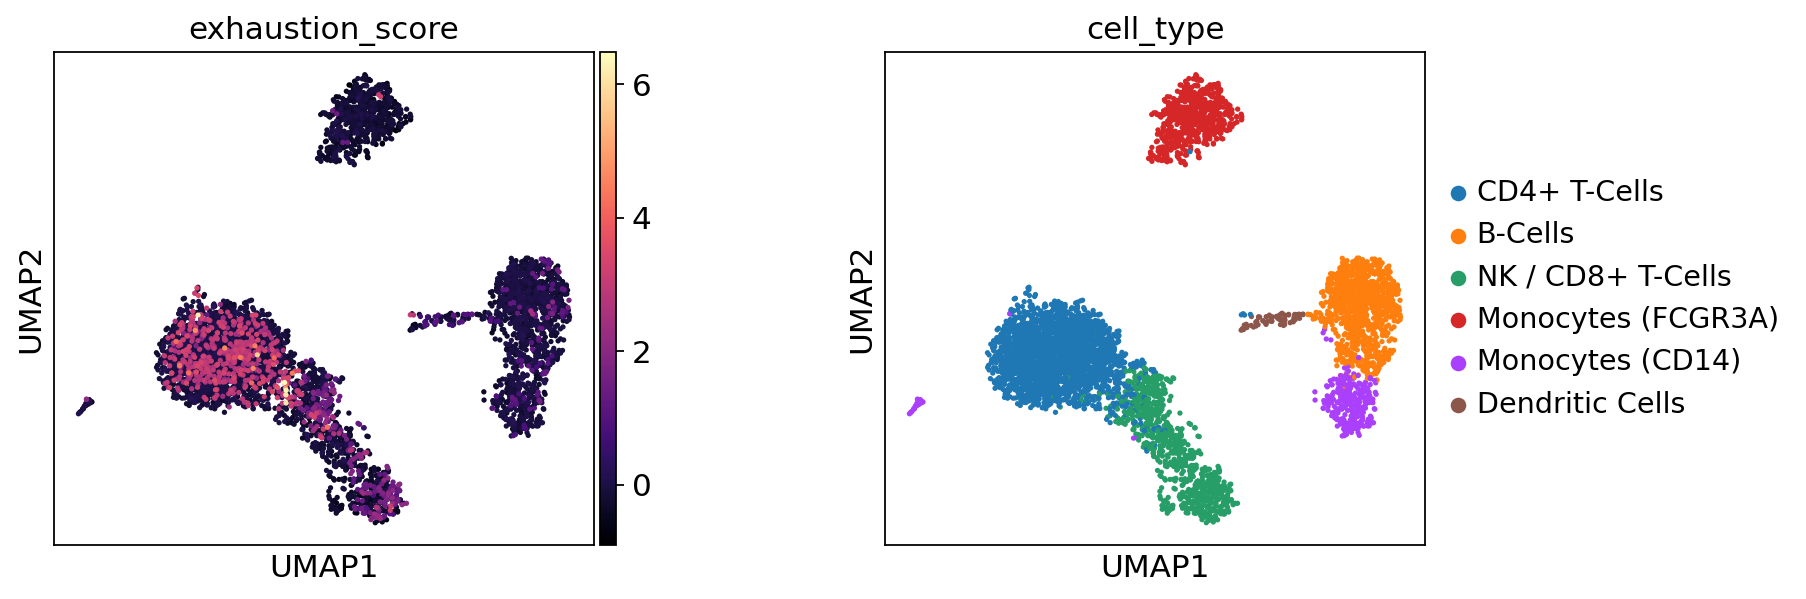


📊 Violin Plot: The REAL Exhaustion Scores


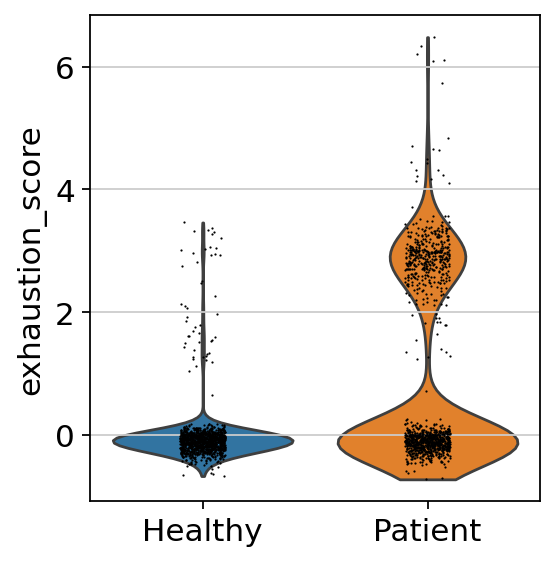

In [7]:
# === PHASE 2, STEP 4: EXHAUSTION SCORING (CORRECTED) ===

# 1. Define the Exhaustion Signature
# These are the classic inhibitory receptors upregulated during T-cell exhaustion
exhaustion_markers = ['PDCD1', 'LAG3', 'HAVCR2', 'CTLA4']

# 2. Calculate Score (FIXED: use_raw=False forces it to look at our spiked data)
sc.tl.score_genes(adata_combined, gene_list=exhaustion_markers, score_name='exhaustion_score', use_raw=False)

# 3. Visualize the Score on the UMAP
print("\n🔥 Heatmap of T-Cell Exhaustion")
sc.pl.umap(adata_combined, color=['exhaustion_score', 'cell_type'], cmap='magma', wspace=0.4)

# 4. Compare Healthy vs Patient
# We isolate ONLY the T-Cells to ensure a fair comparison
t_cells_only = adata_combined[adata_combined.obs['cell_type'] == 'CD4+ T-Cells']

print("\n📊 Violin Plot: The REAL Exhaustion Scores")
sc.pl.violin(t_cells_only, keys='exhaustion_score', groupby='dataset', rotation=0)

In [9]:
# === PHASE 2, STEP 5: SAVE INTEGRATED DATA ===
adata_combined.write('pbmc3k_cancer_integrated.h5ad')
print("✅ Phase 2 Complete. Integrated data saved.")

✅ Phase 2 Complete. Integrated data saved.
